# Basic can collector
Assume a robot whose objective is to recollect cans for recycling. It has the ability of choosing among three options: search for cans, wait and recharge its battery. It also lives in a two-state world: it could either have a low or high battery. If it has high battery and decides to search for cans, then it has an (1-\alpha) probability of turning into the low state battery. If it has low battery, it has a (1-\beta) probability of its battery dying and then needing rescue (which results in a highly negative reward). If it decides to wait, it will have a small negative reward and its battery state won't change. If it decides to recharge, it also gets a small negative reward but its state turns to high.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
class CanCollector:
    def __init__(self, alpha=0.8, beta=0.6, rsearch=0.6, rwait=-1,
                 rdead=-5, rrecharge=0):
        self.alpha = alpha
        self.beta = beta
        self.rsearch = rsearch
        self.rwait = rwait
        self.rdead = rdead
        self.rrecharge = rrecharge
        
        self.state = 1  # 1 is High, 0 is Low
        self.score = 0
        self.action_sequence = []
        self.reward_sequence = []
        self.state_sequence = []
        self.nrounds = 0
        self.last_reward = np.nan
    
    def reset(self):
        self.state = 1  # 1 is High, 0 is Low
        self.score = 0
        self.action_sequence = []
        self.reward_sequence = []
        self.state_sequence = []
        self.nrounds = 0
        self.last_reward = np.nan
    
    def search(self):
        if self.state == 1:
            # High battery
            if np.random.random() >= self.alpha:
                self.state = 0
            return self.rsearch
        else:
            # Low battery
            if np.random.random() >= self.beta:
                self.state = 1
                return self.rdead
            return self.rsearch
        
    def recharge(self):
        self.state = 1 - self.state
        return self.rrecharge
    
    def wait(self):
        return self.rwait
    
    def play(self, action):
        '''Use s, w, r or 0, 1, 2'''
        state = self.state
        if action=='s' or action==0:
            self.last_reward = self.search()
        elif action=='w' or action==1:
            self.last_reward = self.wait()
        elif action=='r' or action==2:
            self.last_reward = self.recharge()
        else:
            raise ValueError('Use any of these actions:"s", "w" or "r"')
            
        self.action_sequence.append(action)
        self.reward_sequence.append(self.last_reward)
        self.state_sequence.append(state)
        self.score += self.last_reward
        self.nrounds += 1
    
    def print(self):
        print('Current state:', self.state)
        print('Score:', self.score)
        print('Sequence:')
        print(list(zip(self.state_sequence, self.action_sequence, self.reward_sequence)))

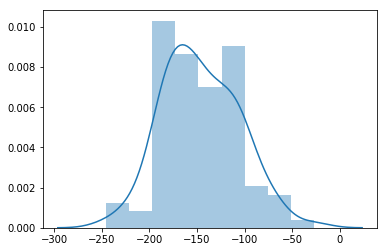

In [3]:
# Cumulative reward of always choosing to search
cc = CanCollector()
scores = []
for _ in range(100):
    cc.reset()
    for _ in range(1000):
        cc.play('s')
    scores.append(cc.score)

sns.distplot(scores)
plt.show()

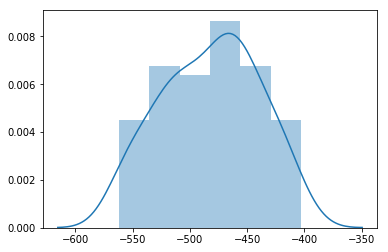

In [4]:
# Cumulative reward of choosing a random action
cc = CanCollector()
scores = []
for _ in range(100):
    cc.reset()
    for _ in range(1000):
        cc.play(np.random.choice(['s', 'w', 'r']))
    scores.append(cc.score)

sns.distplot(scores)
plt.show()

In [5]:
class Player:
    '''Build an e-greedy player'''
    def __init__(self, game, actions, e):
        self.game = game
        self.actions = actions
        self.e = e
        self.data = {}
        self.states = []
        self.potential_actions = {}
    
    def reset(self):
        self.data = {}
        self.states = []
        self.potential_actions = {}
        self.game.reset()
    
    def play(self, n=1):
         # If the game has entered into a new state
        if self.game.state not in self.states:
            self.potential_actions[self.game.state] = [(self.game.state, a) for a in self.actions]
            self.states.append(self.game.state)
            self.data = {**self.data, **{a:{'history':[], 'mean':0} for a in self.potential_actions[self.game.state]}}
        
        potential_actions = self.potential_actions[self.game.state]
        if np.random.random() > self.e * len(potential_actions):
            choice = np.argmax([self.data[act]['mean'] for act in potential_actions])
        else:
            choice = np.random.randint(0, len(potential_actions))
        state_action = potential_actions[choice]
        
        self.game.play(state_action[1])
        self.data[state_action]['history'].append(self.game.last_reward)
        self.data[state_action]['mean'] = np.mean(self.data[state_action]['history'])

In [6]:
# Play a complety greedy player
player = Player(CanCollector(), ['s', 'w', 'r'], 0)
for _ in range(1000):
    player.play()
player.game.print()

Current state: 1
Score: 501.00000000000756
Sequence:
[(1, 's', 0.6), (1, 's', 0.6), (1, 's', 0.6), (1, 's', 0.6), (1, 's', 0.6), (0, 's', 0.6), (0, 's', -5), (1, 's', 0.6), (0, 'w', -1), (0, 'r', 0), (1, 's', 0.6), (1, 's', 0.6), (1, 's', 0.6), (1, 's', 0.6), (1, 's', 0.6), (1, 's', 0.6), (0, 'r', 0), (1, 's', 0.6), (1, 's', 0.6), (1, 's', 0.6), (1, 's', 0.6), (1, 's', 0.6), (1, 's', 0.6), (1, 's', 0.6), (0, 'r', 0), (1, 's', 0.6), (1, 's', 0.6), (1, 's', 0.6), (1, 's', 0.6), (1, 's', 0.6), (0, 'r', 0), (1, 's', 0.6), (1, 's', 0.6), (1, 's', 0.6), (1, 's', 0.6), (1, 's', 0.6), (1, 's', 0.6), (1, 's', 0.6), (1, 's', 0.6), (1, 's', 0.6), (1, 's', 0.6), (1, 's', 0.6), (1, 's', 0.6), (0, 'r', 0), (1, 's', 0.6), (0, 'r', 0), (1, 's', 0.6), (0, 'r', 0), (1, 's', 0.6), (0, 'r', 0), (1, 's', 0.6), (1, 's', 0.6), (1, 's', 0.6), (0, 'r', 0), (1, 's', 0.6), (0, 'r', 0), (1, 's', 0.6), (0, 'r', 0), (1, 's', 0.6), (1, 's', 0.6), (1, 's', 0.6), (1, 's', 0.6), (1, 's', 0.6), (1, 's', 0.6), (1, 's', 0

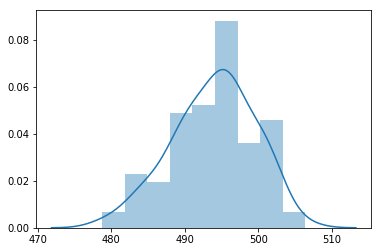

In [7]:
scores = []
for _ in range(100):
    player.reset()
    for _ in range(1000):
        player.play()
    scores.append(player.game.score)

sns.distplot(scores)
plt.show()

In [8]:
[(k, v['mean'], len(v['history'])) for k,v in player.data.items()]

[((1, 's'), 0.5999999999999998, 846),
 ((1, 'w'), 0, 0),
 ((1, 'r'), 0, 0),
 ((0, 's'), -2.2, 2),
 ((0, 'w'), -1.0, 1),
 ((0, 'r'), 0.0, 151)]

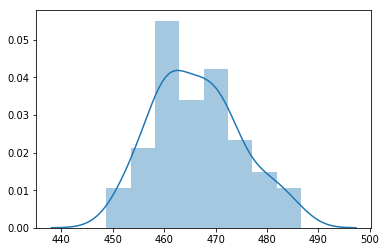

In [9]:
# Play an 99% greedy player
player = Player(CanCollector(), ['s', 'w', 'r'], 0.01)
scores = []
for _ in range(100):
    player.reset()
    for _ in range(1000):
        player.play()
    scores.append(player.game.score)

sns.distplot(scores)
plt.show()

In [10]:
[(k, v['mean'], len(v['history'])) for k,v in player.data.items()]

[((1, 's'), 0.5999999999999999, 811),
 ((1, 'w'), -1.0, 10),
 ((1, 'r'), 0.0, 7),
 ((0, 's'), -3.6, 4),
 ((0, 'w'), -1.0, 3),
 ((0, 'r'), 0.0, 165)]